## 数据准备

In [1]:
from ginkgo.data import *

In [2]:
stock_list = get_stockinfos()

没有缓存，重新计算并缓存


🗿 Got 5375 records about StockInfo from mysql.

In [3]:
stock_code = "000002.SZ"
stock_info = stock_list[stock_list["code"]==stock_code]
display(stock_info)

,code,code_name,industry,currency,market,list_date,delist_date,uuid,meta,desc,create_at,update_at,is_del,source
268,000002.SZ,万科A,全国地产,CURRENCY_TYPES.CNY,MARKET_TYPES.CHINA,1991-01-29,2100-01-01,0dd3cddd92c246698ed3f6aa5b1521f0,{},"This man is lazy, there is no description.",2024-12-04 17:33:10,2024-12-09 00:17:25,False,SOURCE_TYPES.TUSHARE


### 数据跨度

In [4]:
start_date = "2000-01-01"
end_date = "2025-01-01"

In [5]:
bar_data_raw = get_bars(code=stock_code, start_date=start_date, end_date=end_date, as_dataframe=True)
display(bar_data_raw.head(2))
bar_data_raw.describe()

,code,open,high,low,close,volume,amount,frequency,uuid,meta,desc,timestamp,source
0,000002.SZ,9.80,10.40,9.6,10.30,45747,46053.45,FREQUENCY_TYPES.DAY,4413c7238c5a44d08061fea0852f2369,{}                                            ...,"This man is lazy, there is no description.    ...",2000-01-04,SOURCE_TYPES.DATABASE
1,000002.SZ,10.35,10.45,10.0,10.04,46137,47348.00,FREQUENCY_TYPES.DAY,a4ecc6096037411281e04e2a5db1dafa,{}                                            ...,"This man is lazy, there is no description.    ...",2000-01-05,SOURCE_TYPES.DATABASE


,open,high,low,close,volume,amount,timestamp
count,5845.000000,5845.000000,5845.000000,5845.000000,5.845000e+03,5.845000e+03,5845
mean,14.630479,14.906712,14.389321,14.647902,7.818154e+05,1.154262e+06,2012-07-08 08:42:32.335329536
min,3.140000,3.200000,3.120000,3.140000,2.334000e+03,2.566000e+03,2000-01-04 00:00:00
25%,8.250000,8.380000,8.140000,8.270000,2.467280e+05,2.164410e+05,2006-04-11 00:00:00
50%,12.300000,12.520000,12.100000,12.300000,5.767120e+05,7.976183e+05,2012-05-15 00:00:00
75%,20.430000,20.730000,20.110000,20.500000,9.688210e+05,1.593419e+06,2018-12-21 00:00:00
max,41.120000,42.240000,40.460000,41.130000,1.097234e+07,2.010649e+07,2024-12-31 00:00:00
std,8.082726,8.247040,7.942681,8.093063,8.785911e+05,1.327240e+06,NaN


In [6]:
bar_data_raw.isnull().sum()

code         0
open         0
high         0
low          0
close        0
volume       0
amount       0
frequency    0
uuid         0
meta         0
desc         0
timestamp    0
source       0
dtype: int64

### 数据清洗

In [7]:
# Clean abnormal open
bar_data_raw = bar_data_raw[bar_data_raw['open'] > 0]

In [8]:
# Clean abnormal high
bar_data_raw = bar_data_raw[bar_data_raw['high'] > 0]

In [9]:
# Clean abnormal low
bar_data_raw = bar_data_raw[bar_data_raw['low'] > 0]

In [10]:
# Clean abnormal close
bar_data_raw = bar_data_raw[bar_data_raw['close'] > 0]

In [11]:
# Clean abnormal volume
bar_data_raw = bar_data_raw[bar_data_raw['volume'] > 0]

In [12]:
# Clean abnormal amount
bar_data_raw = bar_data_raw[bar_data_raw['amount'] > 0]

In [13]:
print(bar_data_raw.columns)

Index(['code', 'open', 'high', 'low', 'close', 'volume', 'amount', 'frequency',
       'uuid', 'meta', 'desc', 'timestamp', 'source'],
      dtype='object')


### 添加特征

In [14]:
bar_data = bar_data_raw.copy()
# remove null line
bar_data = bar_data.dropna().reset_index(drop=True).copy()
bar_data.describe()

,open,high,low,close,volume,amount,timestamp
count,5845.000000,5845.000000,5845.000000,5845.000000,5.845000e+03,5.845000e+03,5845
mean,14.630479,14.906712,14.389321,14.647902,7.818154e+05,1.154262e+06,2012-07-08 08:42:32.335329536
min,3.140000,3.200000,3.120000,3.140000,2.334000e+03,2.566000e+03,2000-01-04 00:00:00
25%,8.250000,8.380000,8.140000,8.270000,2.467280e+05,2.164410e+05,2006-04-11 00:00:00
50%,12.300000,12.520000,12.100000,12.300000,5.767120e+05,7.976183e+05,2012-05-15 00:00:00
75%,20.430000,20.730000,20.110000,20.500000,9.688210e+05,1.593419e+06,2018-12-21 00:00:00
max,41.120000,42.240000,40.460000,41.130000,1.097234e+07,2.010649e+07,2024-12-31 00:00:00
std,8.082726,8.247040,7.942681,8.093063,8.785911e+05,1.327240e+06,NaN


In [15]:
# remove columns
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'amount']

bar_data = bar_data_raw[feature_columns].copy()
print(bar_data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'amount'], dtype='object')


#### 预测目标

In [16]:
# add target, y in predict
target_span = 5
bar_data.loc[:, 'target'] = (bar_data['close'].shift(-target_span) - bar_data['close']) / bar_data['close']

In [17]:
display(bar_data)

,open,high,low,close,volume,amount,target
0,9.80,10.40,9.60,10.30,45747,46053.45,0.052427
1,10.35,10.45,10.00,10.04,46137,47348.00,0.041833
2,10.00,10.60,9.85,10.51,71920,74244.34,-0.006660
3,10.58,11.00,10.46,10.99,136349,147505.74,-0.087352
4,10.68,11.44,10.55,11.44,142425,159259.05,-0.094406
...,...,...,...,...,...,...,...
5840,7.71,7.73,7.47,7.54,1517662,1146549.84,NaN
5841,7.50,7.56,7.48,7.51,710188,534064.46,NaN
5842,7.51,7.63,7.49,7.55,1004323,760189.35,NaN
5843,7.50,7.51,7.33,7.36,1338890,990277.59,NaN


#### 其他特征

In [18]:
# 涨跌幅
bar_data.loc[:, 'return_1d'] = (bar_data['close'] - bar_data['open'])/bar_data['open']

In [19]:
# 高低价波动幅度
bar_data.loc[:,'hl_range'] = (bar_data['high'] - bar_data['low'])/bar_data['low']

In [20]:
# 收盘价相对最高最低值的位置
bar_data.loc[:,'close_position'] = (bar_data['close'] - bar_data['low'])/(bar_data['high'] - bar_data['low'])

In [21]:
# 成交量变化率
bar_data.loc[:,'volume_change'] = bar_data['volume'] / bar_data['volume'].shift(1) - 1

In [22]:
# 成交额变化率
bar_data.loc[:,'amount_change'] = bar_data['amount'] / bar_data['amount'].shift(1) - 1

In [23]:
# 成交量均值
volume_spans = [2,3,4,5,6,7,8,9, 10, 15, 18,20]
for i in volume_spans:
    bar_data.loc[:,f'volume_ma{i}'] = bar_data['volume'].rolling(window=i).mean()

In [24]:
# 波动率
volatility_spans = [2,3,4,5,6,7,8,9, 10, 15, 18,20]
for i in volatility_spans:
    bar_data.loc[:,f'volatility_{i}d'] = bar_data['close'].rolling(window=i).std()

In [25]:
bar_data.describe()

,open,high,low,close,volume,amount,target,return_1d,hl_range,close_position,...,volatility_4d,volatility_5d,volatility_6d,volatility_7d,volatility_8d,volatility_9d,volatility_10d,volatility_15d,volatility_18d,volatility_20d
count,5845.000000,5845.000000,5845.000000,5845.000000,5.845000e+03,5.845000e+03,5840.000000,5845.000000,5845.000000,5841.000000,...,5842.000000,5841.000000,5840.000000,5839.000000,5838.000000,5837.000000,5836.000000,5831.000000,5828.000000,5826.000000
mean,14.630479,14.906712,14.389321,14.647902,7.818154e+05,1.154262e+06,0.001816,0.001513,0.035668,0.480733,...,0.289422,0.323665,0.354339,0.382202,0.408060,0.432265,0.455111,0.554846,0.606710,0.638946
std,8.082726,8.247040,7.942681,8.093063,8.785911e+05,1.327240e+06,0.063681,0.023614,0.021243,0.288822,...,0.323005,0.347751,0.371565,0.394152,0.415323,0.435234,0.454029,0.534743,0.575553,0.600481
min,3.140000,3.200000,3.120000,3.140000,2.334000e+03,2.566000e+03,-0.512391,-0.126697,0.000000,0.000000,...,0.005000,0.005477,0.008367,0.019024,0.025495,0.030732,0.030912,0.038073,0.045532,0.057956
25%,8.250000,8.380000,8.140000,8.270000,2.467280e+05,2.164410e+05,-0.030495,-0.011579,0.020927,0.228571,...,0.104243,0.120955,0.134052,0.144272,0.153791,0.163018,0.171468,0.216470,0.238189,0.253963
50%,12.300000,12.520000,12.100000,12.300000,5.767120e+05,7.976183e+05,-0.000865,0.000000,0.030053,0.466667,...,0.182289,0.205353,0.229438,0.250590,0.269596,0.284639,0.305123,0.361384,0.400521,0.425503
75%,20.430000,20.730000,20.110000,20.500000,9.688210e+05,1.593419e+06,0.031368,0.012472,0.044340,0.723502,...,0.357395,0.397718,0.435438,0.461321,0.497334,0.532512,0.566595,0.689689,0.771312,0.822983
max,41.120000,42.240000,40.460000,41.130000,1.097234e+07,2.010649e+07,0.457865,0.127204,0.201342,1.000000,...,4.302488,3.994650,3.823212,3.749633,3.910141,4.114000,4.351486,4.658534,4.708030,4.760656


In [26]:
print(bar_data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'amount', 'target',
       'return_1d', 'hl_range', 'close_position', 'volume_change',
       'amount_change', 'volume_ma2', 'volume_ma3', 'volume_ma4', 'volume_ma5',
       'volume_ma6', 'volume_ma7', 'volume_ma8', 'volume_ma9', 'volume_ma10',
       'volume_ma15', 'volume_ma18', 'volume_ma20', 'volatility_2d',
       'volatility_3d', 'volatility_4d', 'volatility_5d', 'volatility_6d',
       'volatility_7d', 'volatility_8d', 'volatility_9d', 'volatility_10d',
       'volatility_15d', 'volatility_18d', 'volatility_20d'],
      dtype='object')


#### 移出缺失值

In [27]:
bar_data = bar_data.dropna().reset_index(drop=True).copy()

## 训练集划分

In [28]:
from sklearn.model_selection import train_test_split
y = bar_data['target'].copy()
x = bar_data.drop(columns=['target']).copy()
# 标准化
def prepare_data():
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test, y_train, y_test

## 真实值与预测值评估方法

In [29]:
import matplotlib.pyplot as plt

def plot_scatter_with_line(y_test, y_test_pred):
    plt.figure(figsize=(10, 5))
    
    # 绘制散点图
    plt.scatter(y_test, y_test_pred, alpha=0.5, label="Truth : Predict")
    
    # 绘制理想的 y=x 线
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    
    plt.xlabel("Truth")
    plt.ylabel("Predict")
    plt.legend()
    plt.title("Result")
    plt.show()

import seaborn as sns

def plot_distribution(y_train, y_test_pred):
    plt.figure(figsize=(10, 5))

    # 查看真实值 y_train 的分布
    sns.histplot(y_train, kde=True, label="y_train", color='blue', alpha=0.5)

    # 查看预测值 y_test_pred 的分布
    sns.histplot(y_test_pred, kde=True, label="y_test_pred", color='red', alpha=0.5)

    plt.legend()
    plt.title("Distribution of y_train vs y_test_pred")
    plt.show()

## 线性回归

In [30]:
# 线性回归
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train, x_test, y_train, y_test = prepare_data()

model = LinearRegression()
model.fit(x_train, y_train)

# 训练集预测
y_train_pred = model.predict(x_train)

# 测试集预测
y_test_pred = model.predict(x_test)

# 计算均方误差 (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# 计算决定系数 (R²)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse:.5f}, R²: {train_r2:.5f}")
print(f"测试集 MSE: {test_mse:.5f}, R²: {test_r2:.5f}")

训练集 MSE: 0.00403, R²: 0.01401
测试集 MSE: 0.00380, R²: 0.00398


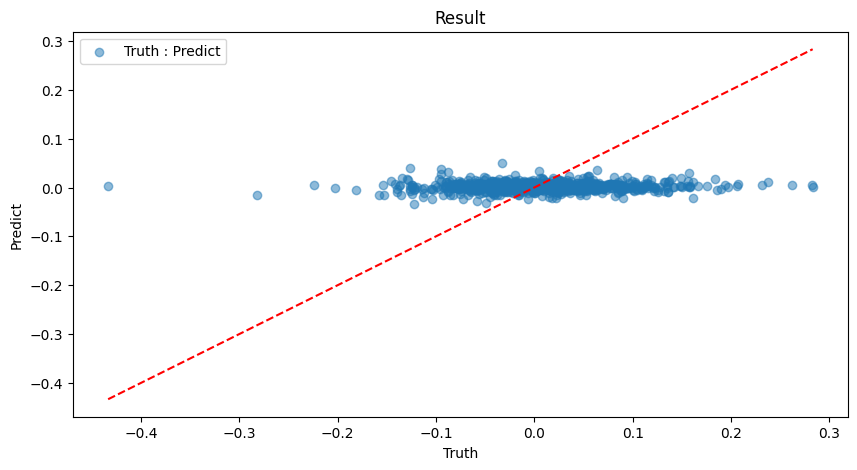

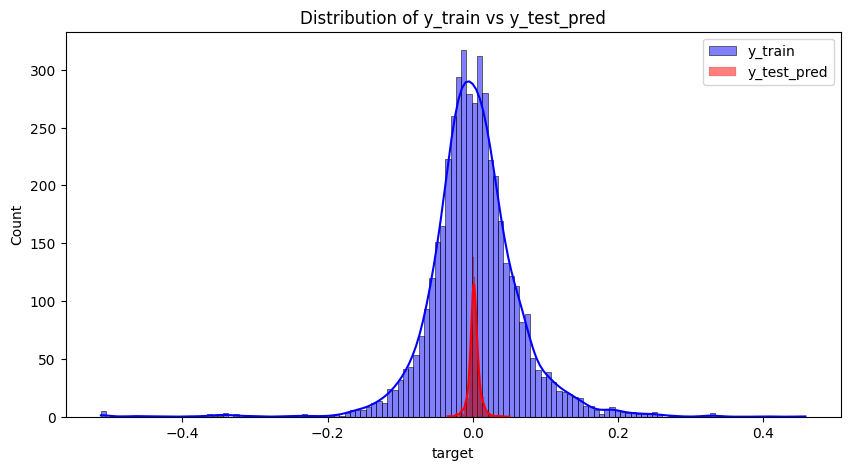

In [31]:
# 评估模型准确
plot_scatter_with_line(y_test, y_test_pred)
plot_distribution(y_train, y_test_pred)

## 决策树

In [32]:
# 决策树
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


x_train, x_test, y_train, y_test = prepare_data()
# 初始化决策树回归模型
model = DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', random_state=42)

# 训练模型
model.fit(x_train, y_train)

# 训练集预测
y_train_pred = model.predict(x_train)

# 测试集预测
y_test_pred = model.predict(x_test)

# 计算均方误差 (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# 计算决定系数 (R²)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse:.5f}, R²: {train_r2:.5f}")
print(f"测试集 MSE: {test_mse:.5f}, R²: {test_r2:.5f}")

训练集 MSE: 0.00187, R²: 0.54322
测试集 MSE: 0.00408, R²: -0.07180


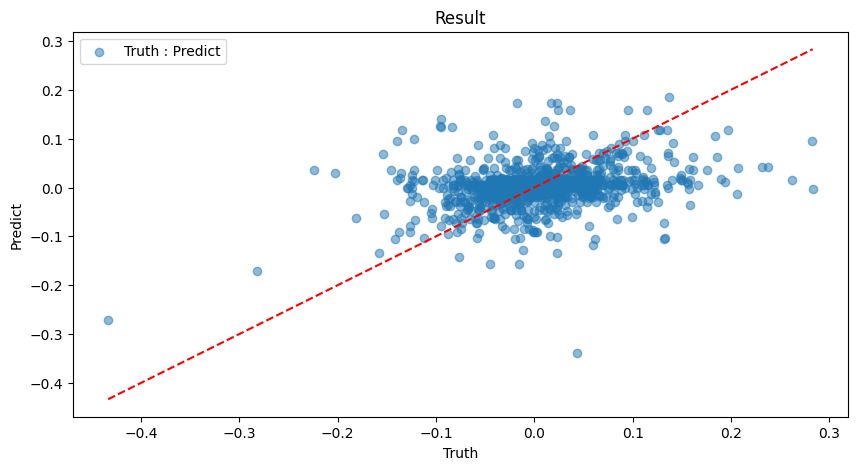

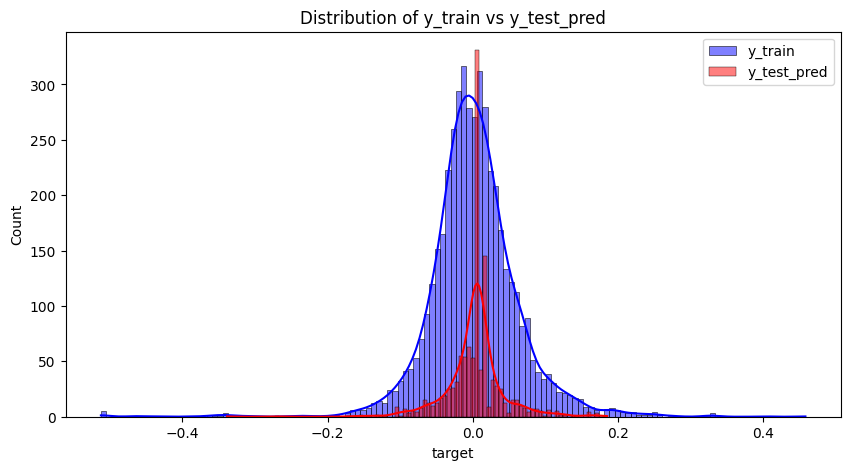

In [33]:
plot_scatter_with_line(y_test, y_test_pred)
plot_distribution(y_train, y_test_pred)

## 随机森林

In [ ]:
# 初始化随机森林回归模型
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# TODO 特征工程

x_train, x_test, y_train, y_test = prepare_data()
param_grid = {
    'n_estimators': [100, 200, 300],        # 树的数量
    'max_depth': [10, 15, 20],       # 最大深度
    'min_samples_split': [5, 10, 20],       # 每个节点最小样本数
    'min_samples_leaf': [2, 5, 10],         # 叶子节点最小样本数
    'max_features': ['sqrt', 'log2'], # 每棵树使用的特征数
}

rf_model = RandomForestRegressor(random_state=42)
# 使用GridSearchCV进行超参数搜索
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')
# 训练模型
grid_search.fit(x_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_

In [ ]:
# 训练集预测
y_train_pred = best_rf_model.predict(x_train)

# 测试集预测
y_test_pred = best_rf_model.predict(x_test)

# 计算均方误差 (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# 计算决定系数 (R²)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse:.5f}, R²: {train_r2:.5f}")
print(f"测试集 MSE: {test_mse:.5f}, R²: {test_r2:.5f}")
plot_scatter_with_line(y_test, y_test_pred)
plot_distribution(y_train, y_test_pred)

## XGBoost

In [ ]:
from xgboost import XGBRegressor
x_train, x_test, y_train, y_test = prepare_data()
param_grid = {
    'n_estimators': [i for i in range(0,300,20)],
    'max_depth': [i for i in range(0,7,1)],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

best_xgb_model = grid_search.best_estimator_

In [ ]:
# 训练集预测
y_train_pred = best_xgb_model.predict(x_train)

# 测试集预测
y_test_pred = best_xgb_model.predict(x_test)

# 计算均方误差 (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# 计算决定系数 (R²)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse:.5f}, R²: {train_r2:.5f}")
print(f"测试集 MSE: {test_mse:.5f}, R²: {test_r2:.5f}")
plot_scatter_with_line(y_test, y_test_pred)
plot_distribution(y_train, y_test_pred)

## 神经网络

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# 定义神经网络类
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # 定义网络层
        self.fc1 = nn.Linear(x_train.shape[1] , 256)  # 输入层到隐藏层
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # 防止过拟合

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
# 初始化网络
model = SimpleNN()
print(model)

In [ ]:
# 定义损失函数和优化器
# criterion = nn.SmoothL1Loss()  # 假设是回归问题，使用均方误差损失

def sharpe_ratio_loss(y_pred, y_true):
    returns = y_pred - y_true
    mean = returns.mean()
    std = returns.std() + 1e-6
    return -mean / std  # 负的 Sharpe Ratio，优化时最小化

criterion = sharpe_ratio_loss

optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32).view(-1, 1)

In [ ]:
# 导入必要的库
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 设置训练的轮次（epoch）
epochs = 10000

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 定义学习率衰减策略，每当验证损失没有改善时，减小学习率
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)  # 每 500 轮降低学习率

# 早停参数
patience = 10  # 当验证损失不再改善超过10轮时停止
best_loss = np.inf
epochs_without_improvement = 0

# 设置训练的轮次（epoch）
for epoch in range(epochs):
    model.train()
    # 1. 清零梯度
    optimizer.zero_grad()
    # 2. 前向传播：计算预测结果
    outputs = model(x_train_tensor)
    # 3. 计算损失
    loss = criterion(outputs, y_train_tensor)
    # 4. 后向传播：计算梯度
    loss.backward()
    # 5. 更新模型参数
    optimizer.step()
    # 6. 更新学习率（每个epoch后调用，但要用验证损失而非训练损失）
    scheduler.step(loss)  # 需要传入验证损失来调整学习率
    # 打印每隔一定轮次的损失值
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    # 检查是否需要早停
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break  # 提前结束训练
torch.save(model.state_dict(), 'test_nn_model.pth')
print("Model saved successfully.")

In [ ]:
# 假设你已经有了验证集的真实值和预测值
val_model = SimpleNN()
val_model.load_state_dict(torch.load('test_nn_model.pth'))
val_model.eval()  # 评估模式
with torch.no_grad():
    # 在验证集上进行预测
    y_val_pred = val_model(x_test_tensor)

# 转换预测值为 NumPy 数组，便于绘图
y_val_pred = y_val_pred.numpy()

# 绘制散点图和分布图
plot_scatter_with_line(y_test_tensor.numpy(), y_val_pred)
plot_distribution(y_test_tensor.numpy(), y_val_pred)